## Comparaison des distances sur des simulations de modèles de ressorts perturbés

Chaque jeu de simulation a été simulé pour des paramètres `(F, k)` fixés. Le bruit et les conditions intiales sont aléatoires et varient selon chaque simulation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import pickle
import os
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 

import descriptor
from descriptor import compute_descriptor
from wasserstein_distance import compute_wasserstein_distance
from kolmogorov_distance import compute_kolmogorov_dist
from data_functions import load_data, plot_data
import simu_ressort

In [2]:
weights = [0.38481898, 0., 0., 0.38481898, 0.07064459, 0.10398312, 0.05573432, 0]
names_desc = ['mean', 'std', 'fr_max', 'ampl_max', 'spectral centroid',
              'spectral width', 'spectral platitude', 'spectral asymetry']

# Check que la somme fait bien 1
print(np.sum(weights))

0.99999999


### Load data

In [3]:
dir_to_load = "data/lung_C_long"

files_to_load = os.listdir(dir_to_load)
all_simus = []

for file in files_to_load:
    data_df = pd.read_csv(dir_to_load + '/' + file)
    data_df = data_df[[col for col in data_df.columns if col[0] == 'V']]
    
    data_np = np.array(data_df).T
    
    # Cut data
    data_np = data_np[:, 50:]
    
    all_simus.append({
        'C': float(file[8:-4]),
        'simu': data_np
    })
    
print("Parameters C:")
print([x['C'] for x in all_simus])

Parameters C:
[0.0015, 0.001, 0.0025, 0.002, 0.0035, 0.003, 0.0045, 0.004, 0.0055, 0.006]


In [4]:
print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['simu'].shape[0]))
print("The duration of each simu is {} dt.".format(all_simus[0]['simu'].shape[1]))

print("{} descripteurs pour chaque simu".format(len(descriptor.compute_descriptor([1, 2]))))

10 parameters tested, and 100 simus for each parameter.
The duration of each simu is 150 dt.
8 descripteurs pour chaque simu


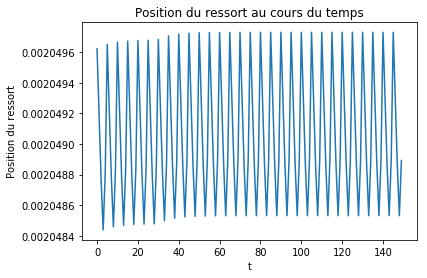

In [5]:
# Exemple
i, j = 1, 10
simu_ressort.plot_ressort(all_simus[i]['simu'][j, :])

#### Mettre sous la forme DataFrame comme les simus de poumons
Format qu'il faudrait que l'on change parce qu'il est pas ouf mais bon...

In [6]:
def plot_df(df, nmax=None, long=None):
    if not nmax:
        nmax = df.shape[1]
    if not long:
        long = df.shape[0]
    for col in df.columns[:nmax]:
        df[col].plot()
    plt.show()

### Calculer les distances entre chaque couple de simus

In [7]:
def compute_dist_sets(sets, weights, name):
    distances = []
    params = []
    
    for data1 in tqdm(sets):
    #for df1 in [sets[42]]:
        for data2 in tqdm(sets):
            kolm_dist = compute_kolmogorov_dist(data1['data'], data2['data'], weights=weights)
            wasser_dist = compute_wasserstein_distance(data1['data'], data2['data'], weights=weights)
            distances.append([kolm_dist, wasser_dist])
            params.append([data1['C'], data2['C']])
            
        # Re enregistre à chaque fois au cas ou ca plante
        simu_ressort.save_obj(distances, './data/lung/distances_' + name + '.pkl')
        simu_ressort.save_obj(params, './data/lung/params_' + name + '.pkl')
            
    return np.array(distances), np.array(params)

In [23]:
sets[0]

{'C': 0.0015,
 'data':            V0        V1        V2        V3        V4        V5        V6  \
 0    0.002920  0.002859  0.002787  0.002948  0.002922  0.003101  0.002916   
 1    0.002919  0.002858  0.002786  0.002947  0.002921  0.003100  0.002914   
 2    0.002918  0.002857  0.002785  0.002946  0.002920  0.003098  0.002913   
 3    0.002917  0.002856  0.002785  0.002945  0.002919  0.003097  0.002913   
 4    0.002918  0.002857  0.002786  0.002946  0.002920  0.003099  0.002913   
 5    0.002920  0.002859  0.002787  0.002948  0.002922  0.003101  0.002916   
 6    0.002919  0.002858  0.002786  0.002947  0.002921  0.003100  0.002914   
 7    0.002918  0.002857  0.002785  0.002946  0.002920  0.003098  0.002913   
 8    0.002917  0.002856  0.002785  0.002945  0.002919  0.003097  0.002913   
 9    0.002918  0.002857  0.002786  0.002946  0.002920  0.003099  0.002913   
 10   0.002920  0.002859  0.002787  0.002948  0.002922  0.003101  0.002916   
 11   0.002919  0.002858  0.002786  0.0029

In [32]:
compute_kolmogorov_dist(sets[2]['data'], sets[3]['data'], weights=weights)

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)


1.0

In [33]:
weights

[0.38481898, 0.0, 0.0, 0.38481898, 0.07064459, 0.10398312, 0.05573432, 0]

**Selectionner que qq jeux de param sinon trop long**

In [8]:
# Sets = liste de dataFrames


def transform_to_df(data, nmax=None):
    df = pd.DataFrame(data)
    df.columns = ['V' + str(i) for i in range(data.shape[1])]
    df = df[['V' + str(i) for i in range(nmax)]]
    return df

sets = []

for i in range(len(all_simus)):
    sets.append({
        'data': transform_to_df(all_simus[i]['simu'].T, nmax=100),
        'C': all_simus[i]['C']
    })

In [9]:
name = ''
distances, params = compute_dist_sets(sets, weights, name)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)

 40%|█████████████████████████████████▏                                                 | 4/10 [01:29<02:14, 22.44s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [52:27<00:00, 314.73s/it]


In [16]:
# Les charger:

distances = simu_ressort.load_obj('./data/lung/distances_' + name + '.pkl')
params = simu_ressort.load_obj('./data/lung/params_' + name + '.pkl')
distances = np.array(distances)
params = np.array(params)


In [30]:
distances

array([[   0.875     ,    0.        ],
       [   1.        ,   91.89050271],
       [   1.        ,   70.08437693],
       [   1.        ,   48.28070771],
       [   1.        ,   95.43174225],
       [   1.        ,   87.22724518],
       [   1.        ,  106.1979257 ],
       [   1.        ,  102.27125373],
       [   1.        ,  110.56734861],
       [   1.        ,  111.88939312],
       [   1.        ,   91.89050271],
       [   0.875     ,    0.        ],
       [   1.        ,  161.75789756],
       [   1.        ,  138.10816871],
       [   1.        ,  187.10287883],
       [   1.        ,  177.91258167],
       [   1.        ,  197.60022492],
       [   1.        ,  193.53479131],
       [   1.        ,  202.21969482],
       [   1.        ,  203.57575569],
       [   1.        ,   70.08437693],
       [   1.        ,  161.75789756],
       [   0.875     ,    0.        ],
       [   1.        ,   31.67937333],
       [   1.        ,   25.64233838],
       [   1.        ,   

## Affichage

In [11]:
def plot_comparaison(distances):
    plt.scatter(distances[:, 0], distances[:, 1], marker='x')
    plt.xlabel("Distance de Kolmogorov")
    plt.ylabel("Distance de Wasserstein")
    plt.title("Comparaison des distances")
    plt.show()

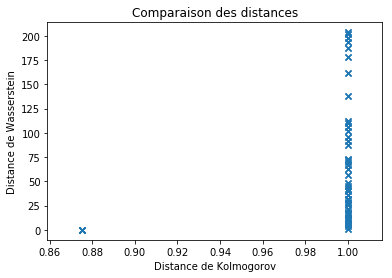

In [12]:
plot_comparaison(distances)

 -> **Kolmogorov à tester en log**

D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


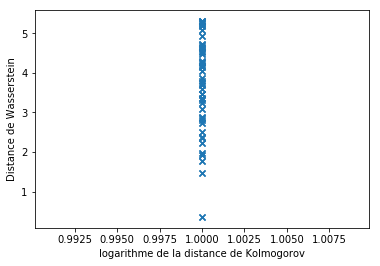

In [13]:
plt.scatter(distances[:, 0], [np.log(x) for x in distances[:, 1]], marker='x')
plt.xlabel('logarithme de la distance de Kolmogorov')
plt.ylabel("Distance de Wasserstein")
plt.show()

In [14]:
distance_by_C = {}

for i in range(len(params)):
    dist_C = abs(params[i, 0] - params[i, 1])
    if dist_C not in distance_by_C:
        distance_by_C[dist_C] = []
    distance_by_C[dist_C].append(distances[i, :])

distance_by_C_moy_kolm = {key: np.mean(np.array(val)[:, 0]) for key, val in distance_by_C.items()}
distance_by_C_moy_wasser = {key: np.mean(np.array(val)[:, 1]) for key, val in distance_by_C.items()}

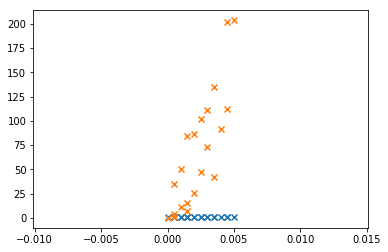

In [19]:
plt.scatter(distance_by_C_moy_kolm.keys(), distance_by_C_moy_kolm.values(), marker='x')
plt.scatter(distance_by_C_moy_wasser.keys(), distance_by_C_moy_wasser.values(), marker='x')
plt.show()